Kvasir dataset split into neg/pos and trained using Resnet50 without augmentation. Getting some decent results after training on resampled data with large step-size.  
- Class weighting  
- Resampling  
- Initial Bias-estimation
- Decreasing learning rate

### Loading data

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [3]:
data_dir = pathlib.Path('/mnt/sdb/hyper-kvasir/labeled/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "model": 'self-trained',
    "ds_info": 'complete',
    "resample": False,
    "neg_class": ['normal-cecum'],
    "num_epochs": 80,
    "batch_size": 128,
    "img_shape": (64, 64, 3),
    "outcast": None,
    "optimizer": 'Adam',
    "final_activation": 'softmax',
    "learning_rate": 0.01,
    "early_stopping_patience": 10,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

fine_tune_from = 130
fine_tune_epochs = 30
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [11]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]
class_names = params["class_names"]
neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

Directories:  ['hemorrhoids' 'barretts' 'esophagitis-a' 'esophagitis-b-d'
 'ulcerative-colitis-0-1' 'barretts-short-segment' 'cecum' 'pylorus'
 'retroflex-rectum' 'ulcerative-colitis-grade-2'
 'ulcerative-colitis-grade-1' 'bbps-2-3' 'bbps-0-1' 'ileum'
 'retroflex-stomach' 'normal-z-line' 'ulcerative-colitis-2-3'
 'impacted-stool' 'polyps' 'dyed-resection-margins' 'dyed-lifted-polyps'
 'ulcerative-colitis-grade-3' 'ulcerative-colitis-1-2']

hemorrhoids                 :    6 | 0.06%
barretts                    :   41 | 0.38%
esophagitis-a               :  403 | 3.78%
esophagitis-b-d             :  260 | 2.44%
ulcerative-colitis-0-1      :   35 | 0.33%
barretts-short-segment      :   53 | 0.50%
cecum                       : 1009 | 9.46%
pylorus                     :  999 | 9.37%
retroflex-rectum            :  391 | 3.67%
ulcerative-colitis-grade-2  :  443 | 4.15%
ulcerative-colitis-grade-1  :  201 | 1.89%
bbps-2-3                    : 1148 | 10.77%
bbps-0-1                    :  646 | 6.

# Step 1
Train a teacher model on labeled images

In [21]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, UpSampling2D, BatchNormalization

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import datetime

### Create and compile the model

In [22]:
resnet_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=config["img_shape"]
)

In [52]:
# Freeze layers in resnet
resnet_model.trainable = True

# Define model
resnet50_model = Sequential()

resnet50_model.add(resnet_model)
resnet50_model.add(GlobalAveragePooling2D())
resnet50_model.add(Dense(params["num_classes"], activation=config["final_activation"]))


if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=config["learning_rate"])

resnet50_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [53]:
if config["verbosity"] > 0:
    resnet50_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                47127     
Total params: 23,634,839
Trainable params: 23,581,719
Non-trainable params: 53,120
_________________________________________________________________


### Callbacks

In [7]:
# By using LearnignRateScheduler
initial_learning_rate = config["learning_rate"]
decay_steps = params["train_size"] // config["batch_size"]
batch_size = config['batch_size']
decay_rate = config['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss',verbose=1, patience=early_stopping_patience, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb, lr_schedule_cb]

# Write config dictionary to text file
f = open(log_dir+"/config.txt","w")
f.write(str(config))
f.close()

### Train the model

In [ ]:
history = resnet50_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

last_epoch = history.epoch[-1]+1

# Write history dictionary to text file
f = open(log_dir+"/history.txt","w")
f.write( str(history.history) )
f.close()

Train for 3731 steps, validate for 799 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/80
3729/3731 [============================>.] - ETA: 0s - loss: 2.1050 - sparse_categorical_accuracy: 0.3001WARNING:tensorflow:From /home/henrik/anaconda3/envs/TF2/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/best_cp-001.hdf/assets
3731/3731 [==============================] - 356s 95ms/step - loss: 2.1044 - sparse_categorical_accuracy: 0.3003 - val_loss: 3.2209 - val_sparse_categorical_accuracy: 0.3648

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009997856262393481.
Epoch 2/80
3731/3731 [==============================] - 158s 42

`Keras`
Save/load the model

In [ ]:
# resnet50_model.save('models/{}.h5'.format(model_name+best_acc))
# resnet50_model = tf.keras.models.load_model('models/{}.h5'.format(model_name+"94"))
resnet50_model = tf.keras.models.load_model("/home/henrik/master_thesis/code/hyper-kvasir/models/best_cp-010.hdf")

## Evaluate the model

In [ ]:
resnet50_evaluate = resnet50_model.evaluate(val_ds, verbose=2, steps=val_steps)

# Write evaluate dictionary to text file
f = open(log_dir+"/evaluate.txt","w")
f.write( str(resnet50_evaluate) )
f.close()

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

lr = history.history['lr']
epochs_range = range(history.epoch[-1]+1)

In [ ]:
# Plot the learning rate
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, lr, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learnign rate')
plt.savefig(log_dir+'/learning_rate.png')
plt.title('Adaptive Learning Rate');

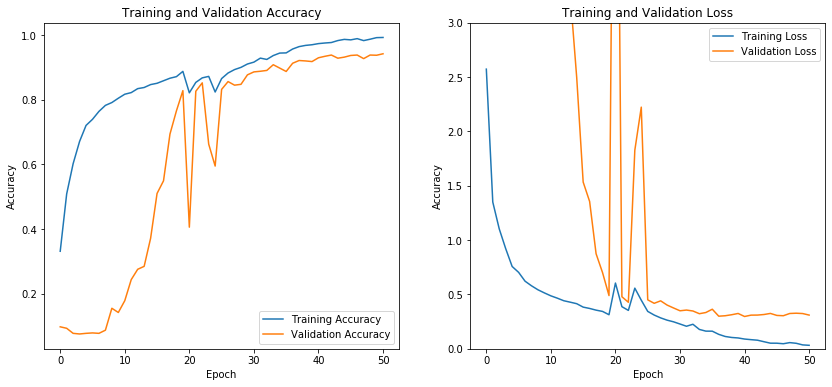

In [22]:
# Plot train-val accuracy and loss
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0.0, 3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.savefig(log_dir+'/accuracy_and_loss.png')
plt.show()

### Fine tune the model

`Tensorboard`

# Step 2  
Use the teacher to generate pseudo labels on unlabeled images

In [23]:
def get_filename(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # the last item of parts is the filename
    filename = parts[-1]
    return filename

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [config["img_shape"][0], config["img_shape"][1] ])

def process_path(file_path):
    filename = get_filename(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, filename

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir_unlabeled = pathlib.Path('/mnt/sdb/hyper-kvasir/unlabeled-test/')

ds_size_unlabeled = len(list(data_dir_unlabeled.glob('*.*g')))

files_string = str(data_dir_unlabeled/'*.*g')
list_ds_unlabeled = tf.data.Dataset.list_files(files_string)

unlabeled_ds = list_ds_unlabeled.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
unlabeled_ds = unlabeled_ds#.batch(1).prefetch(buffer_size=AUTOTUNE)

Next hurdle: get access to both dataset sample and prediction.  
- Predict one and one image?
- Predict all at once?  

This method works, but predicts one image at a time.. Slow?

In [ ]:
# Take one image of unlabeled-test set
for img, name in unlabeled_ds.take(1):
    # Convert to numpy and add dimension
    print (name.numpy())
    show_image(img.numpy())
    img = np.expand_dims(img.numpy(), 0)
    prediction = resnet50_model.predict(img, verbose=1)
    for i, pred in enumerate(prediction[0]):
        print("{:0.2f}% {}".format(pred*100, class_names[i]))

label :  ulcerative-colitis-grade-2
1/1 [==============================] - 0s 14ms/sample
0.00% hemorrhoids
0.00% barretts
0.00% esophagitis-a
0.00% esophagitis-b-d
5.00% ulcerative-colitis-0-1
0.00% barretts-short-segment
5.22% cecum
0.00% pylorus
0.01% retroflex-rectum
76.01% ulcerative-colitis-grade-2
8.20% ulcerative-colitis-grade-1
0.00% bbps-2-3
0.22% bbps-0-1
0.80% ileum
0.00% retroflex-stomach
0.00% normal-z-line
1.13% ulcerative-colitis-2-3
0.00% impacted-stool
0.01% polyps
0.00% dyed-resection-margins
0.00% dyed-lifted-polyps
2.81% ulcerative-colitis-grade-3
0.59% ulcerative-colitis-1-2


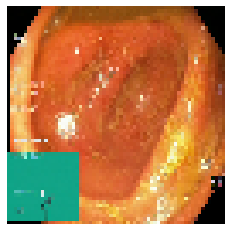

In [69]:
# Take one batch of validation data
for images, labels in val_ds.take(1):
    # Take one image and convert it to numpy
    img = images.numpy()[0]
    lab = labels.numpy()[0]
    # Add one dimension
    print ("label : ", class_names[lab])
    show_image(img)
    img = np.expand_dims(img, 0)
    
    prediction = resnet50_model.predict(img, verbose=1)
    for i, pred in enumerate(prediction[0]):
        print("{:0.2f}% {}".format(pred*100, class_names[i]))

In [ ]:
unlabeled_pred = resnet50_model.predict(unlabeled_ds, verbose=1)

In [ ]:
for sample, prediction in zip(unlabeled_ds, unlabeled_pred):
    pass
#     print (sample)
#     if idx > 5:
#         sys.exit(1)
#     idx += 1


# count = 0
# predictions = unlabeled_pred[count]

# for i, pred in enumerate(predictions):
#     print("{:0.4f} {}".format(pred, class_names[i]))
# print ("Predicton:", class_names[np.argmax(predictions)])

# plt.figure(frameon=False, facecolor='white')
# plt.imshow(image)
# plt.axis('off');

In [ ]:
print (class_names[np.argmax(prediction)])

In [ ]:
for i, pred in enumerate(prediction):
    print("{:0.4f} {}".format(pred, class_names[i]))

In [ ]:
show_image(sample[0].numpy()[0])

In [ ]:
sample[1].numpy()[0]

## Predict new samples

In [ ]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

In [ ]:
# Get a random image and label
rand = np.random.randint(0, config["batch_size"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resnet50_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred, class_names[i]))

print ("\nLabel:", class_names[label])
print ("Predicton:", class_names[np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [ ]:
# Predict one batch
predictions = resnet50_model.predict(images)

print ('{:3}  {:<27} {:27}'.format('idx', 'label', 'pred'))
print ('---  {} {}'.format(27*'-', 27*'-'), end='')

# make a list to store the wrong predictions
wrong_predictions = []

for i, pred in enumerate(predictions):
    label = class_names[labels[i]]
    prediction = class_names[np.argmax(pred)]
    print ('\n{:3}  {:27} {:27}'.format(i, label, prediction), end='')
    if (label != prediction): 
        print ("-Incorrect-", end='')
        wrong_predictions.append(i)

In [ ]:
# Print info about wrong predictions
print("List of wrong predictions from batch:" ,wrong_predictions)
color_string = "\x1b[31m{:0.4f} {}\x1b[0m"

for i, wrong_pred in enumerate(wrong_predictions):
    
    image = images[wrong_pred]
    label = labels[wrong_pred]
    
    # Predict one image
    predictions = resnet50_model.predict(np.expand_dims(image, axis=0))[0]
    pred_label = np.argmax(predictions)
    
    print ("\n\nLabel:", class_names[label])
    print ("Predicton:", class_names[pred_label])
    print ("-------------------------------------")
    for i, pred in enumerate(predictions):
        # print in colors
        if i == pred_label:
            print(color_string.format(pred, class_names[i]))
        else:
            print("{:0.4f} {}".format(pred, class_names[i]))

#     plt.figure(frameon=False, facecolor='white')
#     plt.imshow(image)
#     plt.axis('off');